In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

In [2]:
sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [4]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
# train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

In [5]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


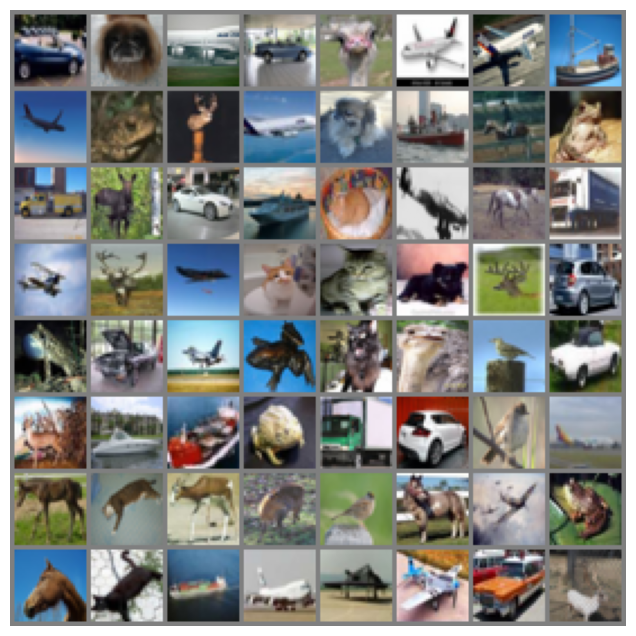

In [6]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## CREATING A CUSTOM CNN ##

In [7]:
from torch.nn.modules.dropout import Dropout
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, input_dim, hidden_units, num_classes):

        super().__init__()

        self.system1 = nn.Sequential(nn.Conv2d(in_channels = input_dim,
                                          out_channels = hidden_units,
                                          kernel_size = 2,
                                          padding = "same"),
                                nn.BatchNorm2d(hidden_units),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 2))

        self.system2 = nn.Sequential(nn.Conv2d(in_channels = hidden_units,
                                               out_channels = hidden_units,
                                               kernel_size = 2,
                                               padding = "same"),
                                  nn.BatchNorm2d(hidden_units),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = hidden_units,
                                               out_channels = hidden_units,
                                               kernel_size = 2,
                                               padding = "same"),
                                  nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.system3 = nn.Sequential(nn.Conv2d(in_channels = hidden_units,
                                               out_channels = hidden_units,
                                               kernel_size = 2,
                                               padding = "same"),
                                  nn.BatchNorm2d(hidden_units),
                                  nn.Tanh(),
                                  nn.Conv2d(in_channels = hidden_units,
                                               out_channels = hidden_units,
                                               kernel_size = 2,
                                               padding = "same"))


        self.dropout = Dropout(0.15)

        self.classification = nn.Sequential(nn.Flatten(),
                                            nn.Linear(in_features = 8 * 8 * hidden_units,
                                                      out_features = 1024),
                                            nn.ReLU(),
                                            nn.Linear(in_features = 1024,
                                                      out_features = num_classes))


    def forward(self, x):

        x = self.system1(x)

        x = self.system2(x)

        x = self.system3(x)

        x = self.dropout(x)

        x = self.classification(x)

        return x


model = Model(3, 30, n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (system1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (system2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(30, 30, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (system3): Sequential(
    (0): Conv2d(30, 30, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(30, 30, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (dropout): Dropout(p=0.15, inplace=False)
  (classificati

In [8]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0015)


In [9]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.02407425  0.02962516 -0.04848377  0.0723297   0.08147299 -0.08012937
   0.10314572  0.10184343 -0.01814373 -0.126088  ]
 [-0.08543217 -0.07078017 -0.13946337 -0.06671754  0.08001182 -0.03021329
  -0.02168452 -0.00986196  0.02435182 -0.02669282]]
Output probabilities:
[[0.09645171 0.10177269 0.09412587 0.10621299 0.10718857 0.09119383
  0.109537   0.10939444 0.09702541 0.08709755]
 [0.09488927 0.09628981 0.08989833 0.0966818  0.11196144 0.10027631
  0.10113519 0.10233797 0.10589992 0.10062994]]


c:\Users\emirh\anaconda3\envs\MachineLearning\Lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv2d(input, weight, bias, self.stride,


In [13]:
torch.cuda.is_available()

True

In [21]:

# printing the number of trainable parameters

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters:", total_params)

Number of trainable parameters: 1992444


## TRAINING

In [14]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.


        output = model(inputs)

        loss = loss_fn(output, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.52940625
             test accuracy: 0.6034
Step 1000    training accuracy: 0.6804042431192661
             test accuracy: 0.6538
Step 1500    training accuracy: 0.69609375
             test accuracy: 0.6764
Step 2000    training accuracy: 0.7573824541284404
             test accuracy: 0.6973
Step 2500    training accuracy: 0.820211038961039
             test accuracy: 0.7073
Step 3000    training accuracy: 0.801375
             test accuracy: 0.7067
Step 3500    training accuracy: 0.8542086693548387
             test accuracy: 0.7197
Step 4000    training accuracy: 0.8973958333333333
             test accuracy: 0.7322
Step 4500    training accuracy: 0.88
             test accuracy: 0.7194
Step 5000    training accuracy: 0.912591314935065
             test accuracy: 0.7299
Step 5500    training accuracy: 0.9320913461538461
             test accuracy: 0.7204
Step 6000    training accuracy: 0.92375
             test accuracy: 0.725
Step 6500    training 